In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# Paths to the files in Google Drive
train_data_path = '/content/drive/My Drive/Train_data.csv'
test_data_path = '/content/drive/My Drive/Test_data.csv'
val_data_path = '/content/drive/My Drive/Val_data.csv'

# Load the CSV files
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
val_data = pd.read_csv(val_data_path)

In [3]:
train_metadata_path = '/content/drive/My Drive/Train_metadata.npy'
test_metadata_path = '/content/drive/My Drive/Test_metadata.npy'
val_metadata_path = '/content/drive/My Drive/Val_metadata.npy'

train_metadata = np.load(train_metadata_path)
test_metadata = np.load(test_metadata_path)
val_metadata = np.load(val_metadata_path)

In [4]:
train_image_features_path = '/content/drive/My Drive/Train_image_features.npy'
test_image_features_path = '/content/drive/My Drive/Test_image_features.npy'
val_image_features_path = '/content/drive/My Drive/Val_image_features.npy'

train_image_features_array  = np.load(train_image_features_path)
test_image_features_array  = np.load(test_image_features_path)
val_image_features_array = np.load(val_image_features_path)

In [5]:
# Extract target labels
y_train = train_data['Recurrence'].map({'Yes': 1, 'No': 0}).values
y_val = val_data['Recurrence'].map({'Yes': 1, 'No': 0}).values
y_test = test_data['Recurrence'].map({'Yes': 1, 'No': 0}).values

# Verify the unique values to confirm conversion
print("Unique values in y_train:", set(y_train))
print("Unique values in y_val:", set(y_val))
print("Unique values in y_test:", set(y_test))



Unique values in y_train: {0, 1}
Unique values in y_val: {0, 1}
Unique values in y_test: {0, 1}


In [6]:
print(f"Train Metadata Shape: {train_metadata.shape}")
print(f"Train Image Features Shape: {train_image_features_array.shape}")
print(f"Train Labels Shape: {y_train.shape}")


Train Metadata Shape: (2834, 79)
Train Image Features Shape: (2834, 768)
Train Labels Shape: (2834,)


Epoch 1/20, Train Loss: 0.3258, Train Accuracy: 0.8571, Validation Loss: 0.0641, Validation Accuracy: 0.9852
Epoch 2/20, Train Loss: 0.0250, Train Accuracy: 0.9968, Validation Loss: 0.0089, Validation Accuracy: 0.9968
Epoch 3/20, Train Loss: 0.0059, Train Accuracy: 0.9989, Validation Loss: 0.0059, Validation Accuracy: 0.9989
Epoch 4/20, Train Loss: 0.0025, Train Accuracy: 0.9996, Validation Loss: 0.0050, Validation Accuracy: 0.9989
Epoch 5/20, Train Loss: 0.0033, Train Accuracy: 0.9989, Validation Loss: 0.0048, Validation Accuracy: 0.9958
Epoch 6/20, Train Loss: 0.0012, Train Accuracy: 1.0000, Validation Loss: 0.0030, Validation Accuracy: 0.9989
Epoch 7/20, Train Loss: 0.0022, Train Accuracy: 0.9989, Validation Loss: 0.0024, Validation Accuracy: 0.9989
Epoch 8/20, Train Loss: 0.0013, Train Accuracy: 0.9996, Validation Loss: 0.0015, Validation Accuracy: 1.0000
Epoch 9/20, Train Loss: 0.0006, Train Accuracy: 1.0000, Validation Loss: 0.0014, Validation Accuracy: 0.9989
Epoch 10/20, Train 

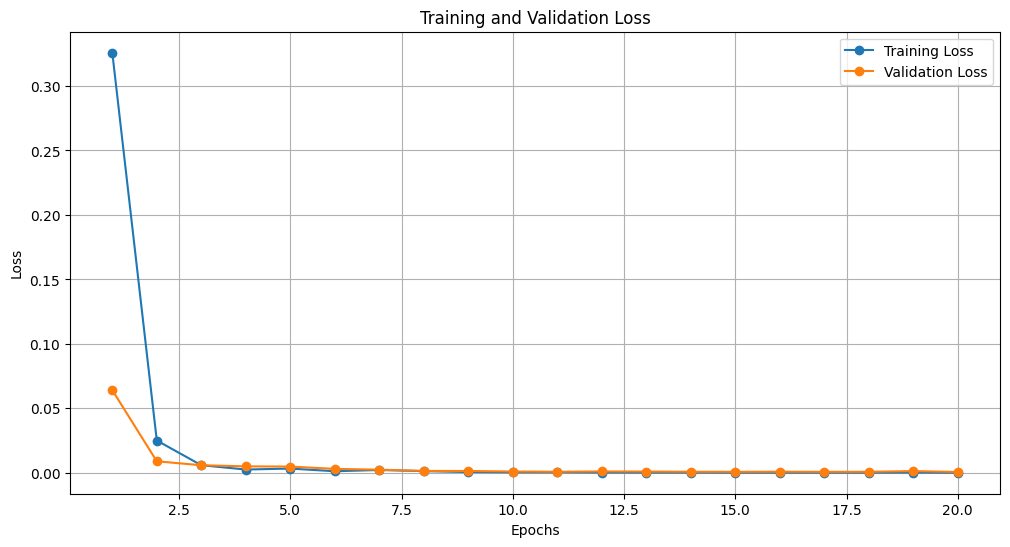

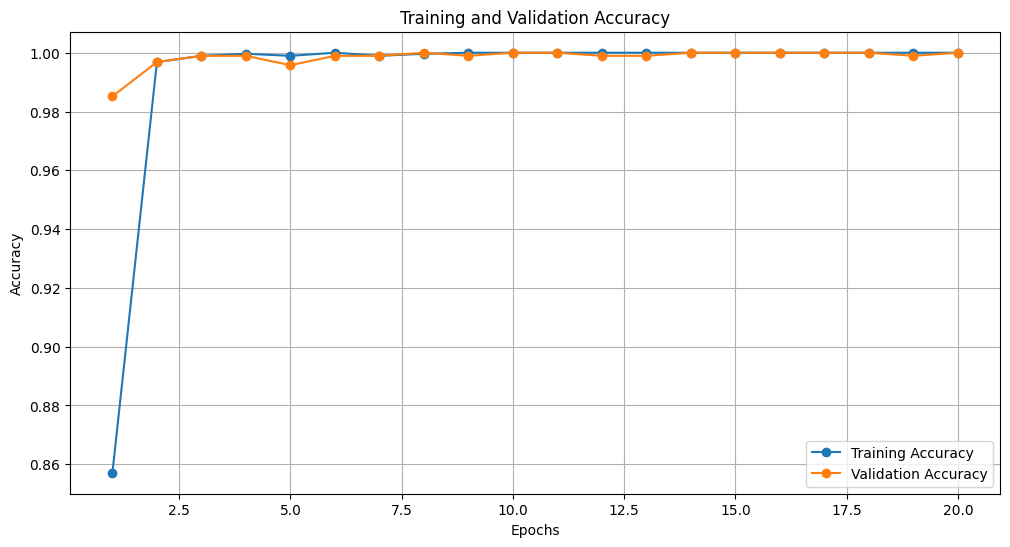

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the PyTorch model
class FusionModel(nn.Module):
    def __init__(self, metadata_dim, image_dim):
        super(FusionModel, self).__init__()
        # Metadata branch
        self.metadata_branch = nn.Sequential(
            nn.Linear(metadata_dim, 64),  # Equivalent to Dense(64)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),  # Equivalent to Dense(32)
            nn.ReLU()
        )
        # Image branch
        self.image_branch = nn.Sequential(
            nn.Linear(image_dim, 128),  # Equivalent to Dense(128)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),  # Equivalent to Dense(64)
            nn.ReLU()
        )
        # Fusion layer
        self.fusion_layer = nn.Linear(32 + 64, 1)  # Concatenate outputs and map to single output
        self.output = nn.Sigmoid()  # Equivalent to Dense(1, activation='sigmoid')

    def forward(self, metadata_input, image_input):
        # Process metadata and image inputs through their branches
        metadata_features = self.metadata_branch(metadata_input)
        image_features = self.image_branch(image_input)
        # Concatenate features
        fusion_features = torch.cat((metadata_features, image_features), dim=1)
        # Final output
        out = self.output(self.fusion_layer(fusion_features))
        return out

# Model parameters
metadata_dim = 79  # Number of metadata features
image_dim = 768  # Dimension of image features
model = FusionModel(metadata_dim, image_dim)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
train_metadata_tensor = torch.tensor(train_metadata, dtype=torch.float32)
train_image_tensor = torch.tensor(train_image_features_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

val_metadata_tensor = torch.tensor(val_metadata, dtype=torch.float32)
val_image_tensor = torch.tensor(val_image_features_array, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training
train_dataset = TensorDataset(train_metadata_tensor, train_image_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_metadata_tensor, val_image_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

import matplotlib.pyplot as plt

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for metadata_batch, image_batch, target_batch in train_loader:
        # Forward pass
        output = model(metadata_batch, image_batch)
        loss = criterion(output, target_batch)
        train_loss += loss.item()

        # Calculate accuracy
        preds = (output >= 0.5).float()  # Threshold at 0.5
        correct_train += (preds == target_batch).sum().item()
        total_train += target_batch.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = correct_train / total_train
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for metadata_batch, image_batch, target_batch in val_loader:
            output = model(metadata_batch, image_batch)
            loss = criterion(output, target_batch)
            val_loss += loss.item()

            # Calculate accuracy
            preds = (output >= 0.5).float()  # Threshold at 0.5
            correct_val += (preds == target_batch).sum().item()
            total_val += target_batch.size(0)

    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

# Final metrics
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [9]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch

# Define a custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, metadata, image_features, labels):
        self.metadata = torch.tensor(metadata, dtype=torch.float32)
        self.image_features = torch.tensor(image_features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.metadata[idx], self.image_features[idx], self.labels[idx]

# Create the test dataset
test_dataset = CustomDataset(test_metadata, test_image_features_array, y_test)

# Define the DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Test Loss: 0.0013
Test Accuracy: 0.9989
Test Precision: 1.0000
Test Recall: 0.9953
Test F1-Score: 0.9977


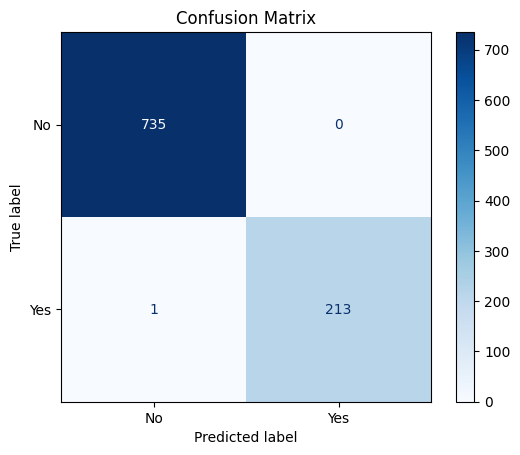

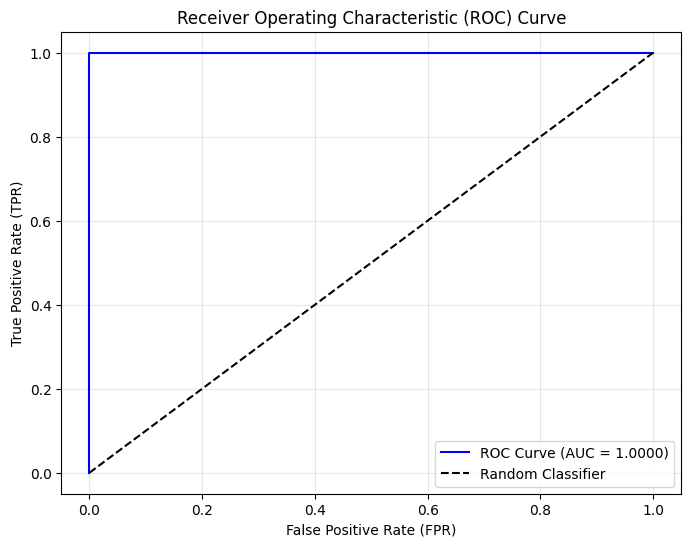

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize lists to store true labels, predictions, and raw outputs
true_labels = []
predicted_labels = []
raw_outputs = []

model.eval()  # Set the model to evaluation mode
test_loss = 0

with torch.no_grad():  # Disable gradient computation
    for metadata_batch, image_batch, target_batch in test_loader:
        # Forward pass
        output = model(metadata_batch, image_batch).squeeze(1)  # Match target shape
        loss = criterion(output, target_batch)  # Binary Cross-Entropy Loss
        test_loss += loss.item()

        # Threshold predictions at 0.5
        preds = (output >= 0.5).float()

        # Store raw outputs, predictions, and true labels
        raw_outputs.extend(output.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(target_batch.cpu().numpy())

# Calculate average loss
test_loss /= len(test_loader)

# Convert to NumPy arrays for metric calculations
true_labels = np.array(true_labels).flatten()
predicted_labels = np.array(predicted_labels).flatten()
raw_outputs = np.array(raw_outputs).flatten()

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels)
test_recall = recall_score(true_labels, predicted_labels)
test_f1 = f1_score(true_labels, predicted_labels)

# Print results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])  # Replace with your class names
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Calculate ROC-AUC
roc_auc = roc_auc_score(true_labels, raw_outputs)
fpr, tpr, thresholds = roc_curve(true_labels, raw_outputs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


In [22]:
# Display confidence scores for each prediction
for i in range(len(true_labels)):
    print(f"Sample {i+1}: True Label = {true_labels[i]}, "
          f"Predicted Label = {predicted_labels[i]}, "
          f"Confidence Score (Probability) = {raw_outputs[i]:.4f}")


Sample 1: True Label = 0.0, Predicted Label = 0.0, Confidence Score (Probability) = 0.0002
Sample 2: True Label = 0.0, Predicted Label = 0.0, Confidence Score (Probability) = 0.0002
Sample 3: True Label = 0.0, Predicted Label = 0.0, Confidence Score (Probability) = 0.0001
Sample 4: True Label = 0.0, Predicted Label = 0.0, Confidence Score (Probability) = 0.0003
Sample 5: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 6: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 7: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 8: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 9: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 10: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.0000
Sample 11: True Label = 1.0, Predicted Label = 1.0, Confidence Score (Probability) = 1.00

In [27]:
# Define thresholds for risk categories
def get_risk_category(probability):
    if probability < 0.3:
        return "Low Risk", "Not Likely to Recur", "Follow-up in 1 - 3 Years"
    elif 0.3 <= probability < 0.7:
        return "Moderate Risk", "Likely to Recur", "Follow-up in 6 - 12 Months"
    else:
        return "High Risk", "Likely to Recur", "Follow-up in 3 - 6 Months"

# Generate recommendations
recommendations = []
for prob in raw_outputs:
    risk_category, binary_prediction, recommendation = get_risk_category(prob)
    recommendations.append((risk_category, binary_prediction, recommendation))

# Display recommendations
for i, (prob, rec) in enumerate(zip(raw_outputs, recommendations)):
    risk_category, binary_prediction, recommendation = rec
    print(f"Sample {i+1}: Probability = {prob:.4f}, "
          f"Binary Prediction = {binary_prediction}, "
          f"Risk Category = {risk_category}, Recommendation = {recommendation}")


Sample 1: Probability = 0.0002, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years
Sample 2: Probability = 0.0002, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years
Sample 3: Probability = 0.0001, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years
Sample 4: Probability = 0.0003, Binary Prediction = Not Likely to Recur, Risk Category = Low Risk, Recommendation = Follow-up in 1 - 3 Years
Sample 5: Probability = 1.0000, Binary Prediction = Likely to Recur, Risk Category = High Risk, Recommendation = Follow-up in 3 - 6 Months
Sample 6: Probability = 1.0000, Binary Prediction = Likely to Recur, Risk Category = High Risk, Recommendation = Follow-up in 3 - 6 Months
Sample 7: Probability = 1.0000, Binary Prediction = Likely to Recur, Risk Category = High Risk, Recommendation = Follow-up in 3 - 6 Months
Sample 8: Probabili

<ipython-input-18-6822dee74e40>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Recurrence', y='Size_cm', data=polyp_data, inner='quartile', palette='muted')


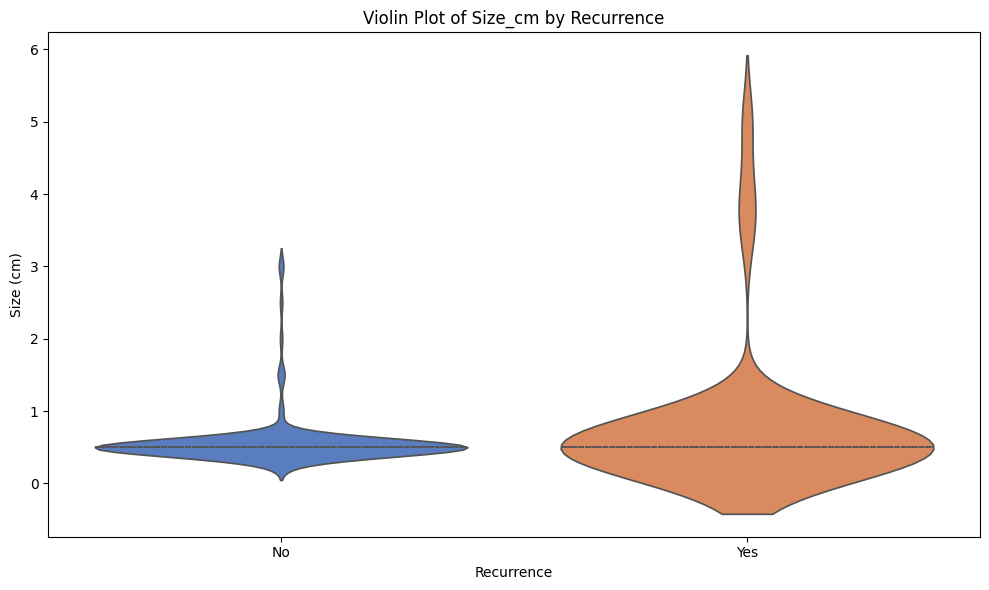

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File path in Google Drive
file_path = '/content/drive/MyDrive/polyp1.xlsx'

# Load the dataset
polyp_data = pd.read_excel(file_path)

# Correct column headers if necessary
polyp_data.columns = polyp_data.columns.str.strip()
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot for 'Size_cm' grouped by 'Recurrence'
plt.figure(figsize=(10, 6))
sns.violinplot(x='Recurrence', y='Size_cm', data=polyp_data, inner='quartile', palette='muted')
plt.title('Violin Plot of Size_cm by Recurrence')
plt.xlabel('Recurrence')
plt.ylabel('Size (cm)')
plt.tight_layout()
plt.show()


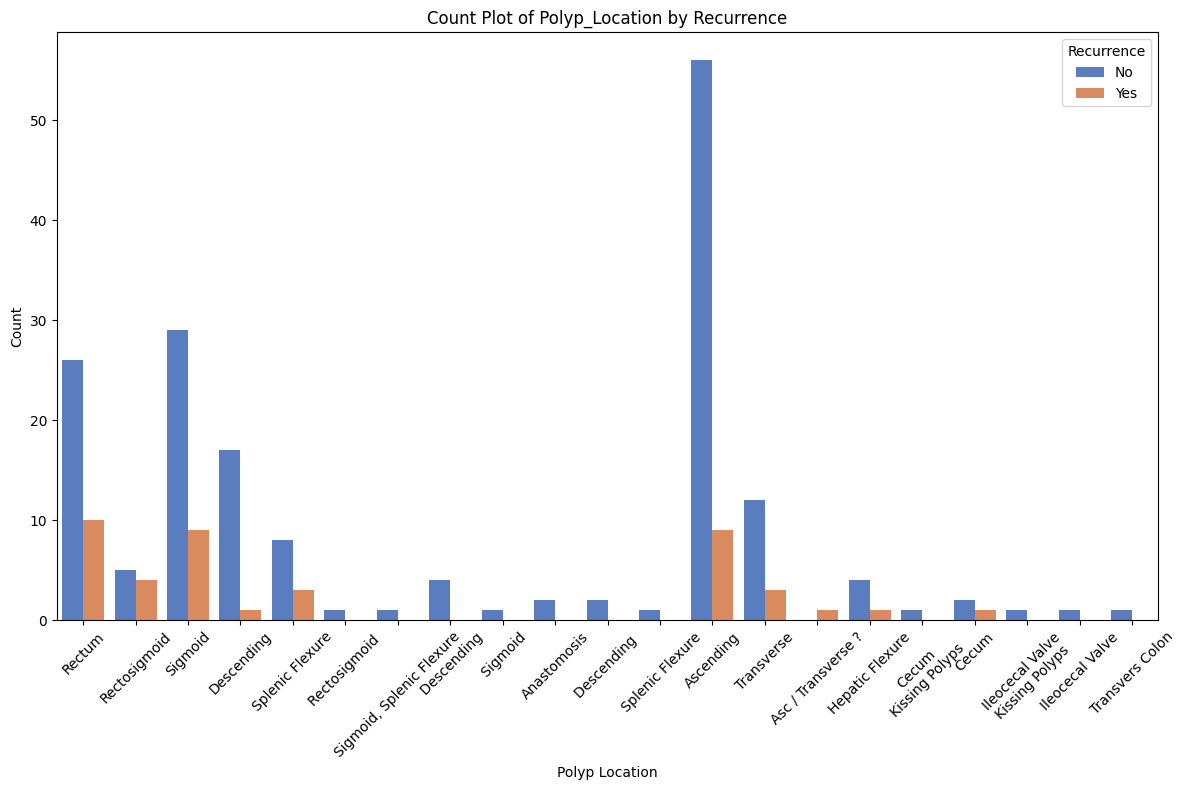

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Polyp_Location', hue='Recurrence', data=polyp_data, palette='muted')
plt.title('Count Plot of Polyp_Location by Recurrence')
plt.xlabel('Polyp Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
